In [6]:
import numpy as np
import jax
from math import comb
import numpy.matlib as mat
import scipy.linalg as la
from scipy.sparse import diags
import os
import time 
from genJ import genJ
import torch
from itertools import combinations
from genGO_vec import genGO
def PhotonTransmission(num):
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
    Hefft = 0

    g3fig = 0
    g3time = 0

    mu = 0
    sigma = 0

    tnum = 2
    t_end = 20

    #plotting parameters
    time_val = 0
    s = 0.2
    lim1 = -80
    lim2 = 80
    wnum = 5000

    minval = 6.66
    # time = 0

    n = [num]

    k = 43      # cavity linewidth (4.3 - Q~100,000, 43 - Q~10,000) 
    k1 = k/2
    k2 = k/2
    go = 0.32  #rabi frequency
    g = 0.043   # emitter linewidth
    Gc = 0      # additional loss channel
    wc = 0      # cavity detuning
    we = 0      # emitter detuning
    J = 0       # dipole-dipole coupling
    w = np.linspace(lim1, lim2, num=wnum)

    for N in n:
        jvec = J*torch.ones(int(N*(N-1)/2))

        Go = go*torch.ones(N)
        G = g*torch.ones(N)
        K = k*torch.ones(N)
        We = we*torch.ones(N)
        

        # values used to dimension the higher excitation hamiltonians
        nck0 = comb(N, 0)
        nck1 = comb(N, 1)

        try:
            nck2 = comb(N,2)
        except:
            nck2 = 0

        try:
            nck3 = comb(N,3)
        except:
            nck3 = 0

        # creation/annihilation operators
        gnd = 1
        a1 = torch.cat((torch.tensor([1]),torch.zeros(N, dtype=torch.cfloat)))
        Heff1=torch.zeros(N+1,N+1, dtype=torch.cfloat)

        Heff1[0,0]= wc - 1j*k/2

        if N > 0:

            Heff1[0,1:N+1] = Go
            Heff1[1:N+1,0] = Go
            Heff1[1:N+1,1:N+1] += (np.diag(We)-1j*np.diag(G)/2)

        J=genJ(jvec)
        Heff1[1:nck0+nck1+1,1:nck0+nck1+1] += J
        lambda1, phi1 = la.eig(Heff1)
        lambda1 = torch.from_numpy(lambda1)
        phi1 = torch.from_numpy(phi1)
        phi1v = la.inv(phi1)
        phi1v = torch.from_numpy(phi1v)
        
        a2 = torch.hstack((torch.eye(N+1, dtype=torch.cfloat), torch.zeros((N+1, 1)).repeat(1,nck2)))
        a2[1] = a2[1]*np.sqrt(2)

        # # a3 = np.zeros((nck0+nck1+nck2,nck0+nck1+nck2+nck3))
        # # a3[0,0] = np.sqrt(3)
        # # a3[1:(nck1+nck0),1:(nck1+nck0)] = np.eye(nck1)*(np.sqrt(2))
        # # a3[nck0+nck1:nck0+nck1+nck2,nck0+nck1:nck0+nck1+nck2] = np.eye(nck2)

        # ## Zeroth excitation subspace
        # Heff0=0

        # ## First Excitation Subspace
        # Heff1=torch.zeros(N+1,N+1, dtype=torch.cfloat)
        # # cavity loss
        # Heff1[0,0]= wc - 1j*k/2 #+1iw comes from the diagonal contribution later
        # # jax.ops.index_update(Heff1, jax.ops.index[0,0], wc - 1j*k/2)
        M = int(1+N*(N+1)/2)
        Heff2=torch.zeros(M,M, dtype=torch.cfloat)
        Heff2[0,0]= 2*(wc - 1j*k/2)
        Heff2[0,1:N+1] = Go*np.sqrt(2)
        Heff2[1:N+1,0] = Go*np.sqrt(2)

        if N > 0:
            # spontaneous emission
            Heff2[1:N+1,1:N+1] = (wc-1j*k/2+(we-1j*g/2))*torch.eye(N)
            comb_vec = torch.tensor([[a[0] + a[1]] for a in combinations((we-1j*g/2)*torch.ones((N,1)),2)])
            Heff2[N+1:,N+1:] = torch.eye(comb_vec.size(0), dtype=torch.cfloat)*comb_vec
            # jax.ops.index_add(Heff1, jax.ops.index[1:N+2,1:N+2], (np.diag(We)-1j*np.diag(G)/2))

        J=genJ(jvec)
        Heff2[nck0:nck0+nck1,nck0:nck0+nck1] += J
        J2 = torch.zeros(comb(N,2),comb(N,2))
        Heff2[nck0+nck1:nck0+nck1+nck2,nck0+nck1:nck0+nck1+nck2] += J2

        GO=genGO(Go)
        r,c=GO.shape
        Heff2[N+1:N+2+r-1,1:2+c-1] += GO
        Heff2[1:2+c-1,N+1:N+2+r-1] += np.transpose(GO)

        lambda2, phi2 = la.eig(Heff2)
        lambda2 = torch.from_numpy(lambda2)
        phi2 = torch.from_numpy(phi2)
        # # print(phi1)
        phi2v = la.inv(phi2)
        phi2v = torch.from_numpy(phi2v)
        # # norm=la.norm(phi1, axis=0)
        # # print(norm)

        w_inc = (lim2-lim1)/wnum
        t_inc = t_end/tnum
        t = torch.zeros(wnum, dtype=torch.cfloat)
        fw2 = torch.zeros(wnum, dtype=torch.cfloat)
        for i in range(0,wnum):
            w_val = lim1+(i+1)*w_inc
            D1 = ((lambda1-w_val)**-1)*torch.eye(N+1)
            D2 = ((lambda2-2*w_val)**-1)*torch.eye(M)
            # print(D1)
            # Transmission
            # current_time = time.time()

            inter3 = torch.matmul(a1,phi1)
            # time3 = time.time()
            # print("time3:", time3-current_time)

            inter2 = torch.matmul(inter3,D1)
            # time2 = time.time()
            # print("time2:", time2-time3)

            inter1 = torch.matmul(inter2,phi1v)
            # time1 = time.time()
            # print("time1:", time1-time2)

            inter0 = torch.matmul(inter1,np.transpose(a1))
            # time0 = time.time()
            # print("time0:", time0-time1)
            t[i] = 1j*np.transpose(gnd)*inter0*gnd

            # interA = inter3 @ phi1v
            # interB = torch.matmul(interA, a2)
            # interC = torch.matmul(interB, phi2)
            # interD = torch.matmul(interC, D2)
            # interE = torch.matmul(interD, phi2v)
            # interF = torch.matmul(interE, np.transpose(a2))
            # interG = torch.matmul(interF, phi1)
            # interJ = torch.matmul(interG, D1)
            # interH = torch.matmul(interJ, phi1v)
            # interI = torch.matmul(interH,np.transpose(a1))
            gwl_diag = torch.diagonal((gnd*gnd)*phi1v@np.transpose(a1)@a1*phi1@D1@phi1v@np.transpose(a1)@a1*phi1@D1,0)
            fwl_diag = torch.diagonal((gnd*gnd)*phi1v@a2@phi2@D2@phi2v@np.transpose(a2)@phi1*D1@phi1v@np.transpose(a1)@a1*phi1,0)
            # print(gwl_diag.size())
            exp_val = torch.exp(-1j*(lambda1-w_val)*time_val)
            some_val = torch.ones(1,N+1) - exp_val
            # print(some_val.size())
            # print(np.transpose(gwl_diag).size())
            fw2[i] = fwl_diag@exp_val + gwl_diag @ some_val.reshape(-1,1)
        #     # jax.ops.index_update(t, jax.ops.index[i], 1j*np.transpose(gnd)*inter0*gnd)

        T=k1*k2*t*np.conj(t)

        tk=np.sqrt(k1*k2)*t
        T_2port=(tk+1)*np.conj(tk+1)

        g2_w=k1**2*k2**2/(T**2)*fw2*np.conj(fw2)
        g2_w_ref=np.abs(-k1*k2*fw2+4*(tk)+2)**2/(T_2port**2)/4

        return w, T, T_2port, g2_w, g2_w_ref


In [9]:
import time
current_time = time.time()

x, y1, y2, y3, y4 = PhotonTransmission(50)
finish_time = time.time()
print(finish_time-current_time)

46.92126703262329


(0.0, 2.0)

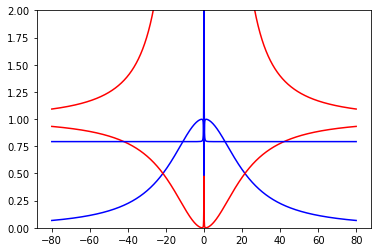

In [4]:
import matplotlib.pyplot as plt
plt.plot(x, y1, 'b')
plt.plot(x, y2, 'r')
plt.plot(x, y3, 'b')
plt.plot(x, y4, 'r')
axes = plt.gca()
# axes.set_xlim([xmin,xmax])
axes.set_ylim([0,2])


In [260]:
import time
import numpy as np

from PhotonTransmission import PhotonTransmission
import matplotlib.pyplot as plt

current_time = time.time()
x, y1, y2 = PhotonTransmission(500)

finish_time = time.time()
print(finish_time-current_time)




13.798386096954346


In [31]:
import numpy as np
import jax
from math import comb
import numpy.matlib as mat
import scipy.linalg as la
from scipy.sparse import diags
import os
import time 
from genJ import genJ
import torch
# import matplotlib as 

def PhotonTransmission(num):
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
    Hefft = 0

    g3fig = 0
    g3time = 0

    mu = 0
    sigma = 0

    tnum = 2
    t_end = 20

    #plotting parameters
    s = 0.2
    lim1 = -80
    lim2 = 80
    wnum = 5000

    minval = 6.66
    # time = 0

    n = [num]

    k = 43      # cavity linewidth (4.3 - Q~100,000, 43 - Q~10,000) 
    k1 = k/2
    k2 = k/2
    go = 0.32  #rabi frequency
    g = 0.043   # emitter linewidth
    Gc = 0      # additional loss channel
    wc = 0      # cavity detuning
    we = 0      # emitter detuning
    J = 0       # dipole-dipole coupling
    w = np.linspace(lim1, lim2, num=wnum)

    for N in n:
        jvec = J*torch.ones(int(N*(N-1)/2))

        Go = go*torch.ones(N)
        G = g*torch.ones(N)
        K = k*torch.ones(N)
        We = we*torch.ones(N)
        

        # values used to dimension the higher excitation hamiltonians
        nck0 = comb(N, 0)
        nck1 = comb(N, 1)

        try:
            nck2 = comb(N,2)
        except:
            nck2 = 0

        try:
            nck3 = comb(N,3)
        except:
            nck3 = 0

        # creation/annihilation operators
        gnd = 1
        a1 = torch.cat((torch.tensor([1]),torch.zeros(N, dtype=torch.cfloat)))
        # a2 = np.hstack((np.eye(N+1), mat.repmat(np.zeros((N+1, 1)), 1, nck2)))
        # a2[1] = a2[1]*np.sqrt(2)

        # a3 = np.zeros((nck0+nck1+nck2,nck0+nck1+nck2+nck3))
        # a3[0,0] = np.sqrt(3)
        # a3[1:(nck1+nck0),1:(nck1+nck0)] = np.eye(nck1)*(np.sqrt(2))
        # a3[nck0+nck1:nck0+nck1+nck2,nck0+nck1:nck0+nck1+nck2] = np.eye(nck2)

        ## Zeroth excitation subspace
        Heff0=0

        ## First Excitation Subspace
        Heff1=torch.zeros(N+1,N+1, dtype=torch.cfloat)
        # cavity loss
        Heff1[0,0]= wc - 1j*k/2 #+1iw comes from the diagonal contribution later
        # jax.ops.index_update(Heff1, jax.ops.index[0,0], wc - 1j*k/2)

        if N > 0:
            # atomic coupling
            print(Go.size())
            Heff1[0,1:N+1] = Go
            # jax.ops.index_update(Heff1, jax.ops.index[0,1:N+2], Go)
            Heff1[1:N+1,0] = Go
            # jax.ops.index_update(Heff1, jax.ops.index[1:N+2,0], Go)

            # spontaneous emission
            Heff1[1:N+1,1:N+1] += (np.diag(We)-1j*np.diag(G)/2)
            # jax.ops.index_add(Heff1, jax.ops.index[1:N+2,1:N+2], (np.diag(We)-1j*np.diag(G)/2))

        J=genJ(jvec)
        Heff1[1:nck0+nck1+1,1:nck0+nck1+1] += J
        # jax.ops.index_add(Heff1, jax.ops.index[1:nck0+nck1+1,1:nck0+nck1+1], J)

        # unsorted phi1
        # print(Heff1)
        lambda1, phi1 = la.eig(Heff1)
        lambda1 = torch.from_numpy(lambda1)
        phi1 = torch.from_numpy(phi1)
        # print(phi1)
        phi1v = la.inv(phi1)
        phi1v = torch.from_numpy(phi1v)
        # norm=la.norm(phi1, axis=0)
        # print(norm)

        w_inc = (lim2-lim1)/wnum
        t_inc = t_end/tnum
        t = torch.zeros(wnum, dtype=torch.cfloat)
        for i in range(0,wnum):
            w_val = lim1+(i+1)*w_inc
            D1 = ((lambda1-w_val)**-1)*torch.eye(N+1)
            # print(D1)
            # Transmission
            # current_time = time.time()

            inter3 = torch.matmul(a1,phi1)
            # time3 = time.time()
            # print("time3:", time3-current_time)

            inter2 = torch.matmul(inter3,D1)
            # time2 = time.time()
            # print("time2:", time2-time3)

            inter1 = torch.matmul(inter2,phi1v)
            # time1 = time.time()
            # print("time1:", time1-time2)

            inter0 = torch.matmul(inter1,np.transpose(a1))
            # time0 = time.time()
            # print("time0:", time0-time1)
            t[i] = 1j*np.transpose(gnd)*inter0*gnd
            # jax.ops.index_update(t, jax.ops.index[i], 1j*np.transpose(gnd)*inter0*gnd)

        T=k1*k2*t*np.conj(t)

        tk=np.sqrt(k1*k2)*t
        T_2port=(tk+1)*np.conj(tk+1)

        return w, T, T_2port


In [32]:
import time
current_time = time.time()

x, y1, y2 = PhotonTransmission(10)
finish_time = time.time()
print(finish_time-current_time)


torch.Size([10])
0.8010663986206055


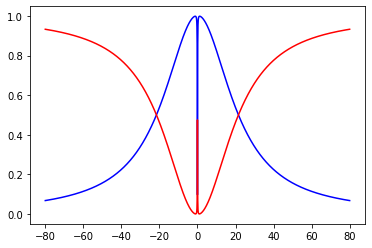

In [33]:
import matplotlib.pyplot as plt
plt.plot(np.transpose(x), y1, 'b')
plt.plot(x, y2, 'r')

In [2]:
from genJ import genJ
import numpy as np

J = genJ(0.2*np.ones(45))
print(J)

[[0.  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.2 0.  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.  0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.  0.2 0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.  0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2 0.  0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2 0.2 0.  0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.  0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.  0.2]
 [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0. ]]


In [1]:
from genJvec import genJvec
import numpy as np

jVec = genJvec(5)
print(jVec)

[12, 13, 14, 15, 23, 24, 25, 34, 35, 45]


In [3]:
from genGO2_vec import genGO2
import numpy as np

GO2 = genGO2(np.array([5,5,5,5,5,5]))
print(GO2)


5
[[5. 5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0.]
 [0. 5. 5. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0.]
 [0. 5. 0. 5. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0.]
 [0. 5. 0. 0. 5. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0.]
 [0. 0. 5. 5. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0.]
 [0. 0. 5. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0.]
 [0. 0. 0. 5. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5.]]
[[5. 5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0.]
 [0. 5. 5. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0.]
 [0. 5. 0. 5. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0.]
 [0. 5. 0. 0. 5. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0.]
 [0. 0. 5. 5. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0.]
 [0. 0. 5. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0.]
 [0. 0. 0. 5. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5.]]
4
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.

In [2]:
from genGO_vec import genGO
import jax.numpy as np

# print(np.zeros((3,0)))

GO = genGO(np.array([0.3200,0.3200,0.3200,0.3200,0.3200,0.3200,0.3200,0.3200,0.3200,0.3200]))
print(GO)

[[0.32 0.32 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.32 0.   0.32 0.   0.   0.   0.   0.   0.   0.  ]
 [0.32 0.   0.   0.32 0.   0.   0.   0.   0.   0.  ]
 [0.32 0.   0.   0.   0.32 0.   0.   0.   0.   0.  ]
 [0.32 0.   0.   0.   0.   0.32 0.   0.   0.   0.  ]
 [0.32 0.   0.   0.   0.   0.   0.32 0.   0.   0.  ]
 [0.32 0.   0.   0.   0.   0.   0.   0.32 0.   0.  ]
 [0.32 0.   0.   0.   0.   0.   0.   0.   0.32 0.  ]
 [0.32 0.   0.   0.   0.   0.   0.   0.   0.   0.32]
 [0.   0.32 0.32 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.32 0.   0.32 0.   0.   0.   0.   0.   0.  ]
 [0.   0.32 0.   0.   0.32 0.   0.   0.   0.   0.  ]
 [0.   0.32 0.   0.   0.   0.32 0.   0.   0.   0.  ]
 [0.   0.32 0.   0.   0.   0.   0.32 0.   0.   0.  ]
 [0.   0.32 0.   0.   0.   0.   0.   0.32 0.   0.  ]
 [0.   0.32 0.   0.   0.   0.   0.   0.   0.32 0.  ]
 [0.   0.32 0.   0.   0.   0.   0.   0.   0.   0.32]
 [0.   0.   0.32 0.32 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.32 0.   0.32 0.   0.   0.   0.  